# Librerias

In [3]:
random_state = 43992294
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import category_encoders as ce
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import SimpleImputer
import seaborn as sns
from scipy.stats import chi2_contingency
import scipy.stats as ss
import os
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MultiLabelBinarizer

from xgboost import XGBClassifier
from sklearn.preprocessing import FunctionTransformer

import ast

import warnings

from tqdm.auto import tqdm

from sklearn.feature_selection import RFECV

from sklearn.ensemble import AdaBoostClassifier

# Import Support Vector Classifier
from sklearn.svm import SVC
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Funciones

In [4]:
def limpiar_y_agrupar(df, columna, umbral=100):
    """
    Limpia y agrupa categorías en una columna específica de un DataFrame.
    Las categorías con frecuencia menor que el umbral se agrupan en 'Otros_{columna}',
    y los valores NaN se reemplazan por 'Desconocidos_{columna}'.

    Parameters:
    - df: DataFrame de pandas.
    - columna: Nombre de la columna a limpiar y agrupar.
    - umbral: Número mínimo de observaciones para mantener una categoría.

    Returns:
    - df: DataFrame con la columna modificada.
    """
    # Contar la frecuencia de cada categoría incluyendo NaN
    conteo_categorias = df[columna].value_counts(dropna=False)
    
    # Identificar categorías con observaciones por debajo del umbral
    categorias_pequenas = conteo_categorias[conteo_categorias < umbral].index

    # Filtrar las categorías poco frecuentes excluyendo NaN
    categorias_pequenas = [cat for cat in categorias_pequenas if pd.notna(cat)]
    
    # Crear valor de relleno para categorías poco frecuentes
    valor_pequeno = f'Otros_{columna}'

    # Crear valor de relleno para NaNs
    valor_desconocido = f'Desconocidos_{columna}'

    # Aplicar la asignación de categorías
    df[columna] = df[columna].apply(
        lambda x: valor_pequeno if x in categorias_pequenas 
                  else (valor_desconocido if pd.isna(x) else x)
    )
    
    return df

def cramers_v(confusion_matrix):
    """
    Calcula la estadística de Cramér's V para medir la asociación entre dos variables categóricas.

    Parameters:
    - confusion_matrix: Matriz de confusión (tabla de contingencia) entre dos variables.

    Returns:
    - Cramér's V: Valor entre 0 y 1 que indica la fuerza de la asociación.
    """
    # Calcular el estadístico chi-cuadrado
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    # Número total de observaciones
    n = confusion_matrix.sum().sum()
    # Obtener el número de filas y columnas de la matriz de confusión
    r, k = confusion_matrix.shape
    if min(r, k) == 1:
        return np.nan  # Evitar dividir por cero
    # Calcular Cramér's V
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))


def expand_list_dummies(df, column, delimiter='|', prefix=None, suffix=None):
    """
    Expande una columna que contiene listas (o cadenas representando listas) en múltiples columnas binarias
    utilizando pandas.get_dummies, una por cada categoría única.

    Parameters:
    - df (pd.DataFrame): DataFrame de pandas.
    - column (str): Nombre de la columna a expandir.
    - delimiter (str): Delimitador a usar en get_dummies. Por defecto es '|'.
    - prefix (str, optional): Prefijo para las nuevas columnas binarias.
    - suffix (str, optional): Sufijo para las nuevas columnas binarias.

    Returns:
    - categories (set): Conjunto de categorías únicas encontradas.
    - df_expanded (pd.DataFrame): DataFrame con las nuevas columnas binarias añadidas y la columna original eliminada.
    """
    # Copiar el DataFrame para evitar modificar el original
    df = df.copy()
    
    # Definir el valor para valores faltantes
    valor_desconocido = f'Desconocidos_{column}'
    
    # Reemplazar NaN por el valor desconocido
    df[column] = df[column].fillna(f'["{valor_desconocido}"]')
    
    # Convertir las cadenas que representan listas en listas reales de Python
    def parse_list(x):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list):
                return parsed
            else:
                return [x]
        except (ValueError, SyntaxError):
            return [x]
    
    df[column] = df[column].apply(parse_list)
    
    # Convertir listas en cadenas separadas por el delimitador
    df['temp_combined'] = df[column].apply(lambda lst: delimiter.join(map(str, lst)))
    
    # Generar las columnas binarias usando get_dummies
    dummies = df['temp_combined'].str.get_dummies(sep=delimiter)
    
    # Añadir prefijo y/o sufijo si se especifica
    if prefix:
        dummies = dummies.add_prefix(f"{prefix}_")
    if suffix:
        dummies = dummies.add_suffix(f"_{suffix}")
    
    # Concatenar las columnas binarias al DataFrame original
    df_expanded = pd.concat([df.drop(columns=[column, 'temp_combined']), dummies], axis=1)
    
    # Obtener las categorías únicas
    categories = set(dummies.columns)
    
    return categories, df_expanded


def categorizar_hora(hora):
    """
    Categoriza una hora dada en 'mañana', 'tarde' o 'noche'.

    Parameters:
    - hora: Cadena de tiempo en formato 'HH:MM:SS'.

    Returns:
    - Categoría de la parte del día: 'mañana', 'tarde' o 'noche'.
    """
    # Extraer la hora como entero
    hora = int(hora.split(':')[0])
    if 0 <= hora < 12:
        return 'mañana'
    elif 12 <= hora < 18:
        return 'tarde'
    else:
        return 'noche'


def convertir_auction_time(df):
    """
    Convierte la columna 'auction_time' de formato timestamp a categorías de parte del día ('mañana', 'tarde', 'noche')
    y crea columnas binarias para cada categoría.

    Parameters:
    - df: DataFrame de pandas.

    Returns:
    - Lista de categorías creadas.
    - df: DataFrame con las nuevas columnas binarias añadidas y las columnas originales eliminadas.
    """
    # Convertir 'auction_time' de timestamp a cadena de tiempo 'HH:MM:SS'
    df['auction_time'] = pd.to_datetime(df['auction_time'], unit='s').dt.strftime('%H:%M:%S')
    
    # Crear una nueva columna con las categorías de parte del día
    df['parte_del_dia'] = df['auction_time'].apply(categorizar_hora)
    
    # Crear columnas binarias para cada parte del día
    df['mañana'] = (df['parte_del_dia'] == 'mañana').astype(int)
    df['tarde'] = (df['parte_del_dia'] == 'tarde').astype(int)
    df['noche'] = (df['parte_del_dia'] == 'noche').astype(int)
    
    # Eliminar las columnas intermedias si no se necesitan
    df.drop(['parte_del_dia', 'auction_time'], axis=1, inplace=True)
    
    return ['mañana', 'tarde', 'noche'], df


def IntFloatToStr(df):
    """
    Limpia los datos del DataFrame convirtiendo cualquier columna que contenga una combinación de 
    strings con enteros o strings con floats a cadenas de texto. Los valores NaN se reemplazan por '0'.

    Parameters:
    - df: DataFrame de pandas.

    Returns:
    - df: DataFrame limpio con las columnas convertidas a strings donde corresponda.
    """
    # Recorrer todas las columnas del DataFrame
    for column in tqdm(df.columns, desc="Limpiando datos"):
        unique_types = df[column].apply(type).unique()
        
        # Verificar si la columna contiene tanto strings como enteros o floats
        if {str, int}.issubset(set(unique_types)) or {str, float}.issubset(set(unique_types)):
            # Convertir todos los valores a string, reemplazando NaN por '0'
            df[column] = df[column].apply(lambda x: str(x) if pd.notna(x) else '0')
    
    return df


def data_cleaning(df):
    """
    Realiza la limpieza y preprocesamiento de un DataFrame siguiendo varios pasos:
    - Convertir y expandir columnas específicas.
    - Agrupar categorías poco frecuentes en columnas categóricas.
    - Limpiar los datos finales.

    Parameters:
    - df: DataFrame de pandas.

    Returns:
    - all_categories: Conjunto de todas las categorías únicas encontradas.
    - df: DataFrame limpio y preprocesado.
    """

    df = df.drop(columns=['device_id'])
    
    all_categories = set()
    
    # Mostrar el tamaño inicial del DataFrame
    print(f"Paso inicial: Tamaño del DataFrame: {df.shape}")

    # Identificar columnas categóricas excluyendo algunas específicas
    categorical_features = [
        col for col in df.select_dtypes(include=['object']).columns.tolist()
        if col not in ['auction_list_0', 'action_list_1', 'action_list_2', 'auction_time']
    ]
    print(f"Paso 1: Columnas categóricas identificadas (excluidas algunas): {categorical_features}")

    # Agrupar categorías poco frecuentes en las columnas categóricas
    for col in tqdm(categorical_features, desc="Agrupando categorías poco frecuentes"):
        print(f"Procesando columna categórica: {col}")
        df = limpiar_y_agrupar(df, col, umbral=100)

    # Mostrar el estado del DataFrame después de agrupar categorías poco frecuentes
    print(f"Paso 2: Tamaño del DataFrame después de agrupar categorías: {df.shape}")

    # Convertir y expandir la columna 'auction_time'
    print(f"Paso 3: Expandiendo la columna 'auction_time'")
    categories_time, df = convertir_auction_time(df)
    all_categories.update(categories_time)
    print(f"Categorías extraídas de 'auction_time': {categories_time}")

    # Expandir la columna 'auction_list_0' usando expand_list_dummies
    print(f"Paso 4: Expandiendo la columna 'auction_list_0'")
    categories_auction, df = expand_list_dummies(
        df, 
        column='auction_list_0', 
        delimiter='|', 
        prefix=None, 
        suffix='auction_list_0'
    )
    all_categories.update(categories_auction)
    print(f"Categorías extraídas de 'auction_list_0': {categories_auction}")

    # Expandir la columna 'action_list_1' usando expand_list_dummies
    print(f"Paso 5: Expandiendo la columna 'action_list_1'")
    categories_action1, df = expand_list_dummies(
        df, 
        column='action_list_1', 
        delimiter='|', 
        prefix=None, 
        suffix='action_list_1'
    )
    all_categories.update(categories_action1)
    print(f"Categorías extraídas de 'action_list_1': {categories_action1}")

    # Expandir la columna 'action_list_2' usando expand_list_dummies
    print(f"Paso 6: Expandiendo la columna 'action_list_2'")
    categories_action2, df = expand_list_dummies(
        df, 
        column='action_list_2', 
        delimiter='|', 
        prefix=None, 
        suffix='action_list_2'
    )
    all_categories.update(categories_action2)
    print(f"Categorías extraídas de 'action_list_2': {categories_action2}")

    # Mostrar el tamaño del DataFrame antes de la limpieza adicional
    print(f"Paso 7: Tamaño del DataFrame antes de la limpieza adicional: {df.shape}")

    # Realizar limpieza adicional de los datos
    df = IntFloatToStr(df)

    # Tamaño final del DataFrame
    print(f"Paso 8: Tamaño final del DataFrame: {df.shape}")

    return all_categories, df

def ajustar_columnas_test(train_df, test_df):
    """
    Asegura que las columnas del conjunto de test coincidan con las del conjunto de entrenamiento,
    con la excepción de que 'Label' no se puede borrar de train y 'id' no se puede borrar de test.
    
    Si faltan columnas en el conjunto de test, se agregan con valor 0.
    Si sobran columnas en el conjunto de test que no están en el de entrenamiento, se eliminan.
    
    Parameters:
    - train_df: DataFrame del conjunto de entrenamiento (con las columnas transformadas)
    - test_df: DataFrame del conjunto de test (sin transformar)
    
    Returns:
    - test_df: DataFrame del conjunto de test con las columnas ajustadas.
    """
    # Encontrar las columnas que están en train pero no en test, excepto 'Label'
    missing_cols = set(train_df.columns) - set(test_df.columns) - {'Label'}

    # Encontrar las columnas que están en test pero no en train, excepto 'id'
    extra_cols = set(test_df.columns) - set(train_df.columns) - {'id'}

    # Agregar las columnas faltantes en el conjunto de test con valor 0
    for col in missing_cols:
        test_df[col] = 0

    # Eliminar las columnas extra del conjunto de test, excepto 'id'
    test_df = test_df.drop(columns=extra_cols)

    # Asegurarse de que las columnas estén en el mismo orden que en el conjunto de entrenamiento
    test_df = test_df[train_df.columns.difference(['Label']).tolist() + ['id']]

    return test_df

def ajustar_columnas_val(train_df, val_df):
    # Encontrar las columnas que están en train pero no en test, excepto 'Label'
    missing_cols = set(train_df.columns) - set(val_df.columns)

    # Encontrar las columnas que están en test pero no en train, excepto 'id'
    extra_cols = set(val_df.columns) - set(train_df.columns)

    # Agregar las columnas faltantes en el conjunto de test con valor 0
    for col in missing_cols:
        val_df[col] = 0

    # Eliminar las columnas extra del conjunto de test, excepto 'id'
    val_df = val_df.drop(columns=extra_cols)

    return val_df

# Función para manejar None en hiperparámetros en el nombre del archivo
def handle_none(value):
    return 'None' if value is None else str(value)


def concatenar(df1, df2):
    # Encontrar las columnas que están en df1 pero no en df2
    missing_cols = set(df1.columns) - set(df2.columns)

    # Encontrar las columnas que están en df2 pero no en df1
    extra_cols = set(df2.columns) - set(df1.columns)

    # Añadir las columnas faltantes en df2 con valores 0
    for col in missing_cols:
        df2[col] = 0

    # Añadir las columnas faltantes en df1 con valores 0
    for col in extra_cols:
        df1[col] = 0

    # Asegurarse de que ambas tengan las mismas columnas en el mismo orden
    df1 = df1[df2.columns]

    # Concatenar los DataFrames
    df_concat = pd.concat([df1, df2], ignore_index=True)

    return df_concat

random_state = 43992294

# Lectura de datos

In [5]:
# train_data_20 = pd.read_csv('data/ctr_20.csv')
train_data_20 = pd.read_csv('train_data_cleaned_20.csv')

test = pd.read_csv('test_data_cleaned.csv')


/var/folders/5k/nl_6tbmj7mx91g71vzpwrch40000gn/T/ipykernel_56894/931980756.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data_20 = pd.read_csv('train_data_cleaned_20.csv')
/var/folders/5k/nl_6tbmj7mx91g71vzpwrch40000gn/T/ipykernel_56894/931980756.py:4: DtypeWarning: Columns (329) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv('test_data_cleaned.csv')


In [6]:
# train_data_20, _ = train_test_split(train_data_20, train_size=100000, stratify=train_data_20['Label'], random_state=random_state)

train_data_20 = IntFloatToStr(train_data_20)

Limpiando datos:   0%|          | 0/461 [00:00<?, ?it/s]

In [14]:
numeric_columns = train_data_20.select_dtypes(include=[np.number]).columns
non_numeric_columns = train_data_20.select_dtypes(exclude=[np.number]).columns

print("Numeric columns:", list(numeric_columns))
print("Numeric columns count:", len(numeric_columns))
print()
print("Non-numeric columns:", list(non_numeric_columns))
print("Non-numeric columns count:", len(non_numeric_columns))

Numeric columns: ['Label', 'auction_age', 'auction_bidfloor', 'creative_height', 'creative_width', 'timezone_offset', 'mañana', 'tarde', 'noche', 'Desconocidos_auction_list_0_auction_list_0', 'IAB-5_auction_list_0', 'IAB1_auction_list_0', 'IAB1-1_auction_list_0', 'IAB1-2_auction_list_0', 'IAB1-3_auction_list_0', 'IAB1-4_auction_list_0', 'IAB1-5_auction_list_0', 'IAB1-6_auction_list_0', 'IAB1-7_auction_list_0', 'IAB10_auction_list_0', 'IAB10-1_auction_list_0', 'IAB10-2_auction_list_0', 'IAB10-3_auction_list_0', 'IAB10-5_auction_list_0', 'IAB10-7_auction_list_0', 'IAB12_auction_list_0', 'IAB12-1_auction_list_0', 'IAB12-2_auction_list_0', 'IAB12-3_auction_list_0', 'IAB13_auction_list_0', 'IAB14_auction_list_0', 'IAB14-1_auction_list_0', 'IAB14-3_auction_list_0', 'IAB14-6_auction_list_0', 'IAB15_auction_list_0', 'IAB15-10_auction_list_0', 'IAB16_auction_list_0', 'IAB17_auction_list_0', 'IAB17-1_auction_list_0', 'IAB17-12_auction_list_0', 'IAB17-26_auction_list_0', 'IAB17-39_auction_list_0'

# Preprocesamiento

## Correlaciones

Correlation of features with 'Label' (sorted by absolute value):
creative_height: 0.1093
auction_bidfloor: 0.0752
healthcare_and_fitness_auction_list_0: 0.0660
creative_width: 0.0650
IAB7_auction_list_0: 0.0647
IAB9-30_auction_list_0: 0.0507
-5603_action_list_2: -0.0503
-6220_action_list_2: -0.0501
-7265_action_list_2: -0.0496
-5604_action_list_2: -0.0495
-6119_action_list_2: -0.0495
-6866_action_list_2: -0.0494
-6865_action_list_2: -0.0493
-6218_action_list_2: -0.0491
-7264_action_list_2: -0.0490
-6867_action_list_2: -0.0489
-7112_action_list_2: -0.0488
-7111_action_list_2: -0.0487
-6224_action_list_2: -0.0487
-5605_action_list_2: -0.0486
-6226_action_list_2: -0.0481
-7263_action_list_2: -0.0474
-6875_action_list_2: -0.0472
-6543_action_list_2: -0.0462
-6946_action_list_2: -0.0450
-6823_action_list_2: -0.0440
-6871_action_list_2: -0.0435
Desconocidos_action_list_2_action_list_2: 0.0430
-7190_action_list_2: -0.0408
-6876_action_list_2: -0.0408
-6544_action_list_2: -0.0404
-6615_action_

/Users/lucamazzarello_/opt/anaconda3/envs/TDVI/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/lucamazzarello_/opt/anaconda3/envs/TDVI/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/lucamazzarello_/opt/anaconda3/envs/TDVI/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


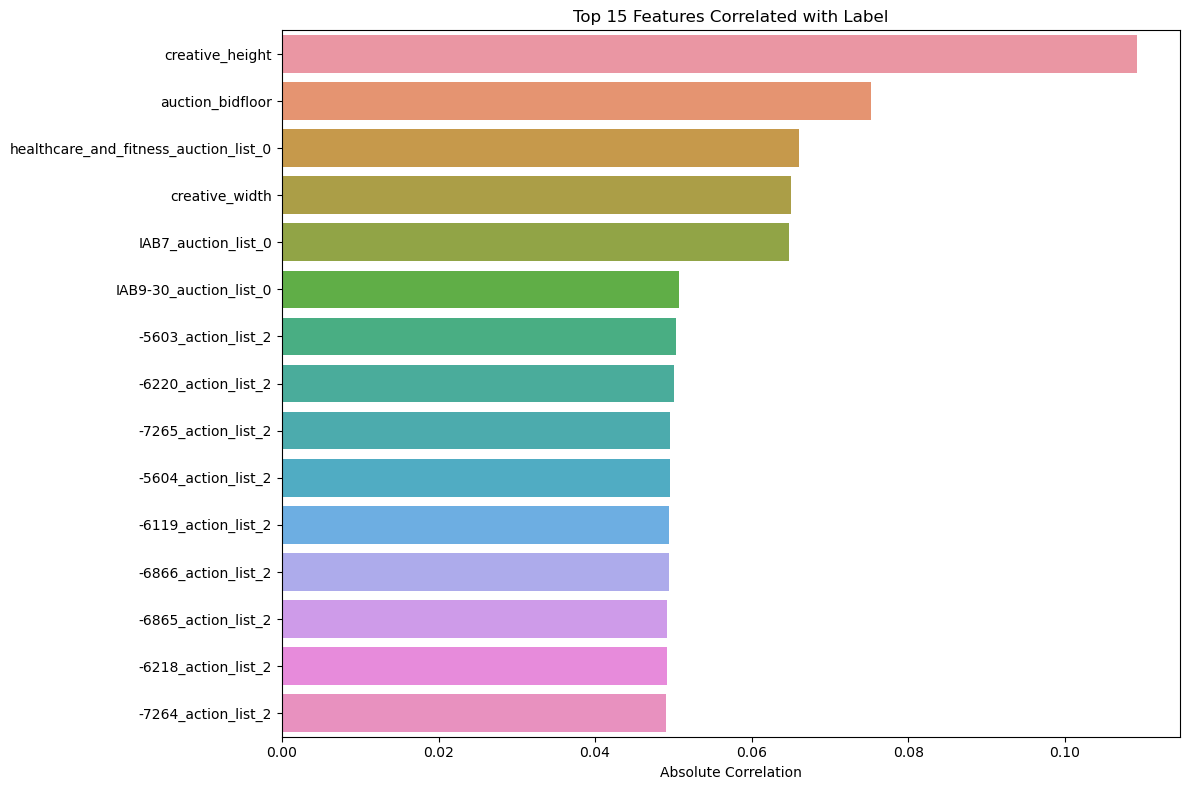

In [10]:
# Correlation analysis with 'Label'
numeric_data = train_data_20[numeric_columns]  # Include 'Label' this time
correlation_with_label = numeric_data.corr()['Label'].sort_values(key=abs, ascending=False)

# Print correlations with 'Label'
print("Correlation of features with 'Label' (sorted by absolute value):")
for feature, corr in correlation_with_label.items():
    if feature != 'Label':
        print(f"{feature}: {corr:.4f}")

# Missing data analysis (unchanged)
missing_data = train_data_20.isnull().sum() / len(train_data_20) * 100
missing_data = missing_data.sort_values(ascending=False)

print("\nPercentage of Missing Data by Feature:")
for feature, percentage in missing_data.items():
    if percentage > 0:  # Only print features with missing data
        print(f"{feature}: {percentage:.2f}%")

# Visualize top correlations with 'Label'
plt.figure(figsize=(12, 8))
top_correlations = correlation_with_label.drop('Label').abs().nlargest(15)
sns.barplot(x=top_correlations.values, y=top_correlations.index)
plt.title('Top 15 Features Correlated with Label')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.show()

Cramer's V for categorical features with 'Label':
auction_categorical_9: 0.2699
auction_categorical_12: 0.2366
auction_categorical_7: 0.2356
creative_categorical_0: 0.1804
action_categorical_4: 0.1659
auction_categorical_11: 0.1157
creative_categorical_9: 0.1072
action_categorical_2: 0.0976
action_categorical_3: 0.0908
action_categorical_1: 0.0907
creative_categorical_2: 0.0860
auction_categorical_0: 0.0852
creative_categorical_6: 0.0829
action_categorical_0: 0.0829
creative_categorical_12: 0.0819
creative_categorical_7: 0.0809
creative_categorical_8: 0.0803
creative_categorical_5: 0.0796
creative_categorical_4: 0.0782
creative_categorical_11: 0.0778
auction_categorical_8: 0.0729
auction_categorical_3: 0.0665
auction_categorical_2: 0.0601
device_id_type: 0.0450
auction_categorical_1: 0.0430
action_categorical_5: 0.0430
action_list_0: 0.0412
auction_categorical_5: 0.0407
auction_categorical_6: 0.0354
creative_categorical_3: 0.0307
auction_boolean_0: 0.0305
creative_categorical_1: 0.0275

/Users/lucamazzarello_/opt/anaconda3/envs/TDVI/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/lucamazzarello_/opt/anaconda3/envs/TDVI/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/lucamazzarello_/opt/anaconda3/envs/TDVI/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/lucamazzarello_/opt/anaconda3/envs/TDVI/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprec

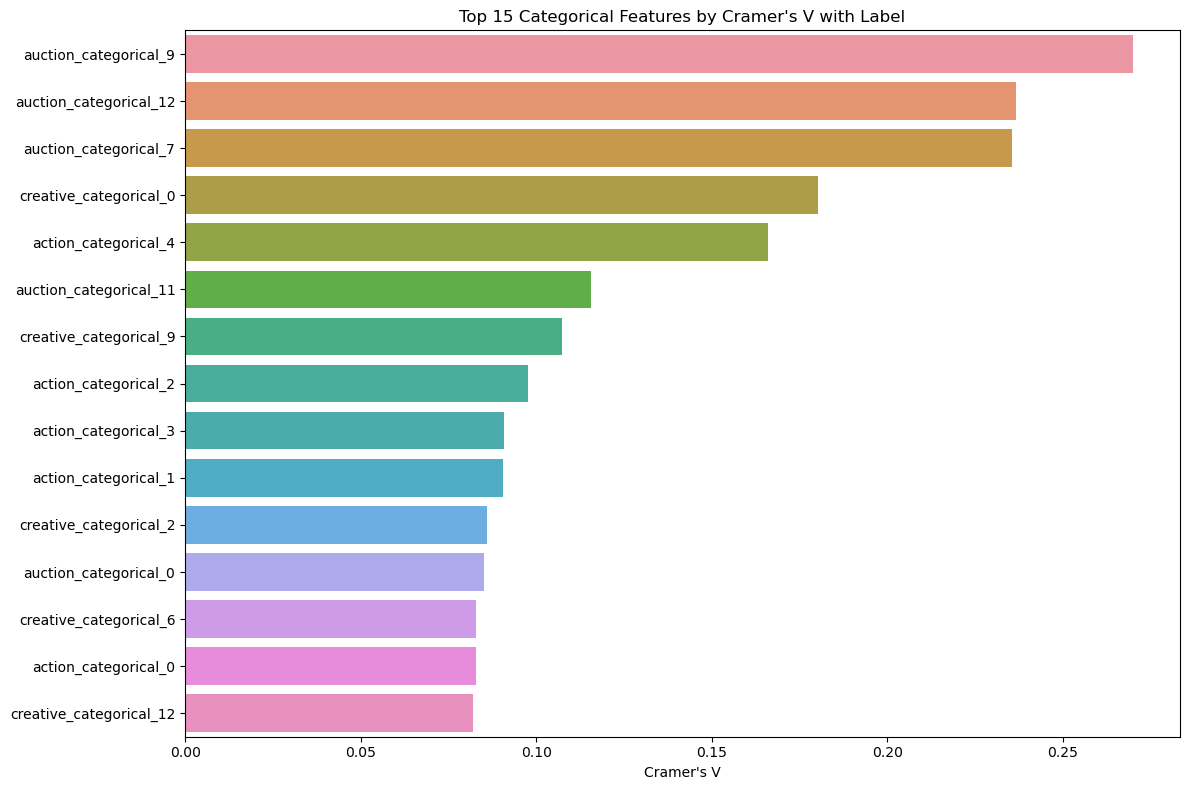


Percentage of Missing Data by Feature:
auction_age: 81.58%
creative_height: 17.91%
creative_width: 17.91%
timezone_offset: 0.04%


In [11]:
# Identify categorical columns
categorical_columns = train_data_20.select_dtypes(include=['object']).columns

# Calculate Cramer's V for each categorical feature with 'Label'
cramer_v_results = {}
for col in categorical_columns:
    confusion_matrix = pd.crosstab(train_data_20[col], train_data_20['Label'])
    cramer_v_results[col] = cramers_v(confusion_matrix)

# Sort results
cramer_v_results = dict(sorted(cramer_v_results.items(), key=lambda item: item[1], reverse=True))

# Print results
print("Cramer's V for categorical features with 'Label':")
for feature, v in cramer_v_results.items():
    print(f"{feature}: {v:.4f}")

# Visualize top Cramer's V results
plt.figure(figsize=(12, 8))
top_features = dict(list(cramer_v_results.items())[:15])  # Top 15 features
sns.barplot(x=list(top_features.values()), y=list(top_features.keys()))
plt.title("Top 15 Categorical Features by Cramer's V with Label")
plt.xlabel("Cramer's V")
plt.tight_layout()
plt.show()

# Missing data analysis (unchanged)
missing_data = train_data_20.isnull().sum() / len(train_data_20) * 100
missing_data = missing_data.sort_values(ascending=False)

print("\nPercentage of Missing Data by Feature:")
for feature, percentage in missing_data.items():
    if percentage > 0:  # Only print features with missing data
        print(f"{feature}: {percentage:.2f}%")

# Comparación de modelos

## Recursive Feature Elimination

In [21]:
# Prepare data for RFECV
X = train_data_20.drop('Label', axis=1)
y = train_data_20['Label']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Combine preprocessor with RFECV
rfe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', RFECV(
        estimator=RandomForestClassifier(random_state=random_state),
        step=1,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    ))
])

rfe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', RFECV(
        estimator=XGBClassifier(random_state=random_state),
        step=1,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    ))
])

# Fit the RFE selectors
print("Fitting Random Forest RFECV...")
rfe_rf.fit(X, y)

print("Fitting XGBoost RFECV...")
rfe_xgb.fit(X, y)

# Get results
print('Optimal number of features (Random Forest model): {}'.format(rfe_rf.named_steps['selector'].n_features_))
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfe_rf.named_steps['selector'].grid_scores_) + 1), rfe_rf.named_steps['selector'].grid_scores_)
plt.title('Feature Number Selection (Random Forest)')
plt.xlabel("Number of Features Selected")
plt.ylabel("CV Score (ROC AUC)")
plt.show()

print('Optimal number of features (XGBoost model): {}'.format(rfe_xgb.named_steps['selector'].n_features_))
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfe_xgb.named_steps['selector'].grid_scores_) + 1), rfe_xgb.named_steps['selector'].grid_scores_)
plt.title('Feature Number Selection (XGBoost)')
plt.xlabel("Number of Features Selected")
plt.ylabel("CV Score (ROC AUC)")
plt.show()

# Get feature names after preprocessing
feature_names = (numeric_features.tolist() +
                 rfe_rf.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names(categorical_features).tolist())

# Print the selected features
print("Features selected by Random Forest:")
selected_features_rf = [feature_names[i] for i, selected in enumerate(rfe_rf.named_steps['selector'].support_) if selected]
print(selected_features_rf)

print("\nFeatures selected by XGBoost:")
selected_features_xgb = [feature_names[i] for i, selected in enumerate(rfe_xgb.named_steps['selector'].support_) if selected]
print(selected_features_xgb)

Fitting Random Forest RFECV...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extension

## Backward Selection

In [7]:
# Dividir los datos en entrenamiento y validación con estratificación
X_train, X_val, y_train, y_val = train_test_split(
    train_data_20.drop(columns='Label'),  # Características
    train_data_20['Label'],               # Variable objetivo
    test_size=0.2,                              # 20% para validación
    stratify=train_data_20['Label'],      # Estratificación basada en la variable objetivo
    random_state=random_state                   # Semilla para reproducibilidad
)

# Asegurarse de que X_train y X_val sean dataframes de pandas
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)

# Asegurarse de que y_train y y_val sean series de pandas
y_train = pd.Series(y_train)
y_val = pd.Series(y_val)

/Users/lucamazzarello_/opt/anaconda3/envs/TDVI/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


                                                Feature  \
5183  creative_categorical_6_Desconocidos_creative_c...   
1                                      auction_bidfloor   
5199                    creative_categorical_8_b00371d3   
2                                       creative_height   
1633  auction_categorical_11_Otros_auction_categoric...   
3                                        creative_width   
3149                     auction_categorical_6_0fa26b70   
3175                     auction_categorical_6_fccb6ea5   
6                                                 tarde   
7                                                 noche   
0                                           auction_age   
968                      auction_categorical_0_431302a4   
5                                                mañana   
1043                     auction_categorical_0_ea238f7b   
100                                 IAB7_auction_list_0   
2453                    auction_categorical_12_b5734977 

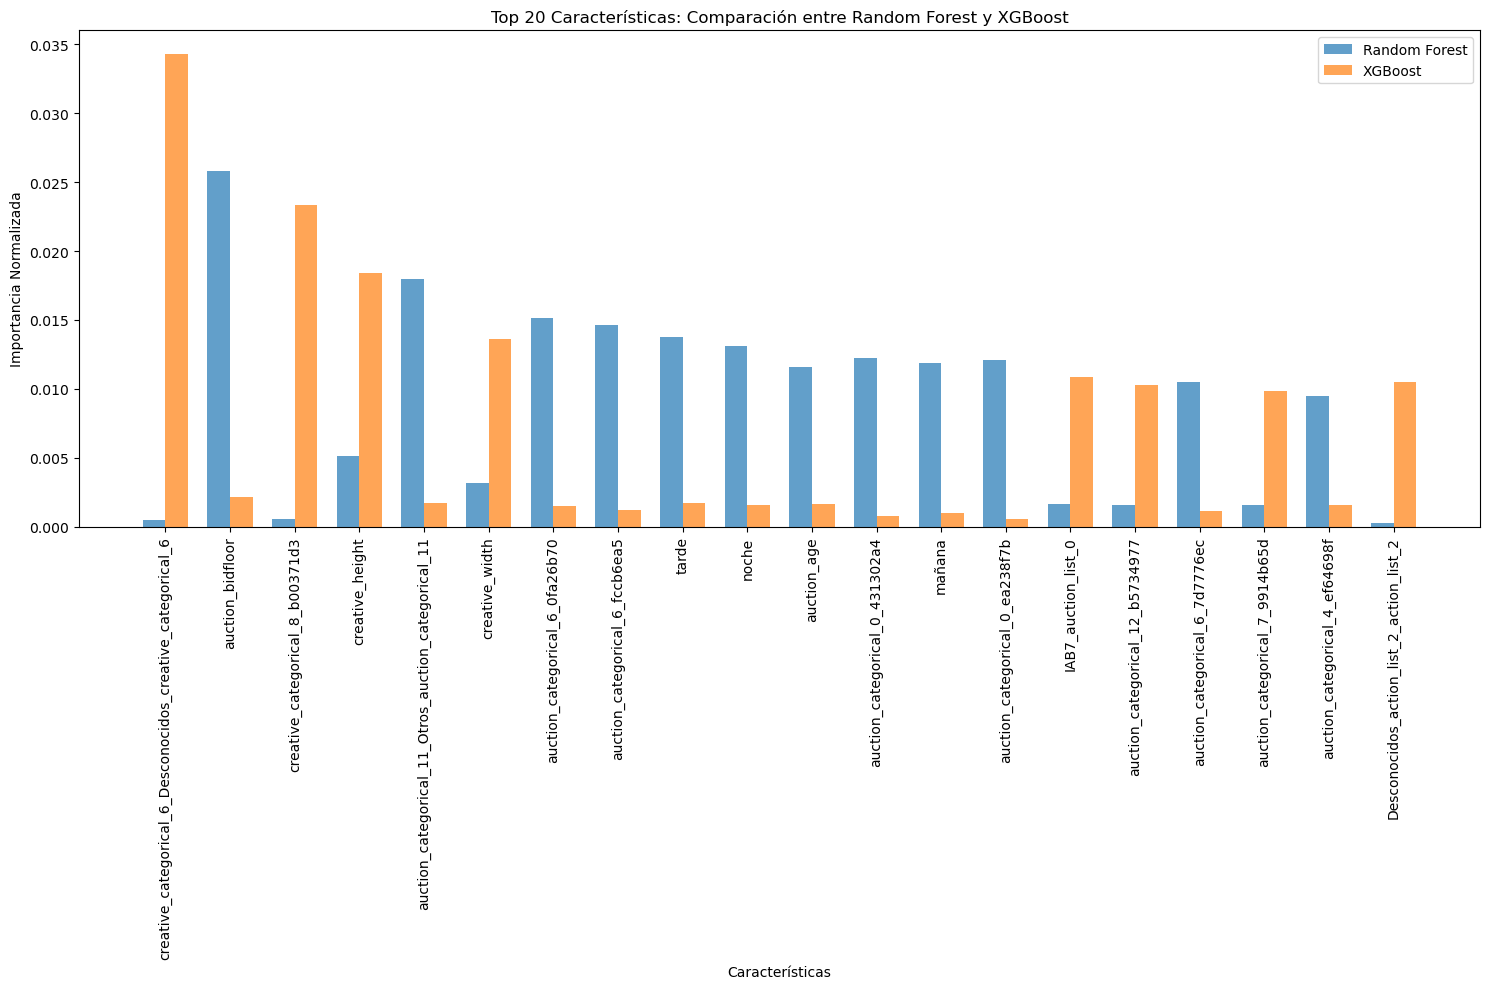

Número de características a mantener: 4
Características a eliminar:
{'auction_categorical_9_5c8425cc', 'auction_categorical_11_b2a2f202', '6848_action_list_2', 'action_categorical_4_51b05430', 'auction_categorical_3_8590bc16', 'auction_categorical_7_8279c09f', 'auction_categorical_9_2efdd33f', 'auction_categorical_9_7444e431', 'creative_categorical_0_ef51b181', 'action_categorical_4_6fdf6bca', 'auction_categorical_12_78238b7e', 'auction_categorical_7_63875f0e', 'action_categorical_4_0f8f1fb0', 'auction_categorical_3_a7690b72', 'auction_categorical_6_0a01d3e2', 'creative_categorical_0_ca6eb111', 'action_categorical_4_cd679903', 'action_categorical_4_b988e13e', 'auction_categorical_3_c5b046f2', 'auction_categorical_11_8bb71caa', 'action_list_0_IAB8-9', 'auction_categorical_0_1c0d07f0', 'auction_categorical_11_9c95f529', 'auction_categorical_11_1bf77585', '6118_action_list_1', 'auction_categorical_0_Otros_auction_categorical_0', 'auction_categorical_9_2c89926d', 'auction_categorical_12_b5

In [13]:
# Identificar las columnas categóricas y numéricas
categorical_columns = X_train.select_dtypes(include=['object']).columns
numeric_columns = X_train.select_dtypes(include=['number']).columns

# Crear un preprocesador con imputación y One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        # Imputar valores numéricos faltantes con la media
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Imputar NaNs con la media
        ]), numeric_columns),
        
        # Imputar valores categóricos faltantes con 'Desconocido' y aplicar One-Hot Encoding
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Desconocido')),  # Imputar NaNs con 'Desconocido'
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # One-Hot Encoding
        ]), categorical_columns)
    ]
)

# Entrenamiento del modelo Random Forest
model_rf = RandomForestClassifier(random_state=random_state)
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model_rf)
])
pipeline_rf.fit(X_train, y_train)

# Entrenamiento del modelo XGBoost
model_xgb = XGBClassifier(random_state=random_state)
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model_xgb)
])
pipeline_xgb.fit(X_train, y_train)

# Obtener los nombres de las características después del One-Hot Encoding
encoded_feature_names = pipeline_rf.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_columns)
all_feature_names = np.concatenate([numeric_columns, encoded_feature_names])

# Crear un DataFrame para comparar las importancias
feature_importances_df = pd.DataFrame({
    'Feature': all_feature_names,
    'RandomForestImportance': pipeline_rf.named_steps['classifier'].feature_importances_,
    'XGBoostImportance': pipeline_xgb.named_steps['classifier'].feature_importances_
})

# Normalizar las importancias
feature_importances_df['RandomForestImportanceNorm'] = feature_importances_df['RandomForestImportance'] / feature_importances_df['RandomForestImportance'].sum()
feature_importances_df['XGBoostImportanceNorm'] = feature_importances_df['XGBoostImportance'] / feature_importances_df['XGBoostImportance'].sum()

# Calcular la importancia promedio
feature_importances_df['AverageImportanceNorm'] = (feature_importances_df['RandomForestImportanceNorm'] + feature_importances_df['XGBoostImportanceNorm']) / 2

# Ordenar por la importancia promedio
feature_importances_df = feature_importances_df.sort_values(by='AverageImportanceNorm', ascending=False)

# Mostrar las 20 características más importantes
print(feature_importances_df.head(20))

# Visualización de la comparación con gráfico de barras (top 20 características)
plt.figure(figsize=(15, 10))
top_20 = feature_importances_df.head(20)
indices = np.arange(len(top_20))
width = 0.35

plt.bar(indices, top_20['RandomForestImportanceNorm'], width=width, label='Random Forest', alpha=0.7)
plt.bar(indices + width, top_20['XGBoostImportanceNorm'], width=width, label='XGBoost', alpha=0.7)

plt.xlabel('Características')
plt.ylabel('Importancia Normalizada')
plt.title('Top 20 Características: Comparación entre Random Forest y XGBoost')
plt.xticks(indices + width / 2, top_20['Feature'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Definir un umbral para la importancia promedio
importance_threshold = 0.003  # Ajusta este valor según tus necesidades

# Identificar características a mantener
features_to_keep = feature_importances_df[feature_importances_df['AverageImportanceNorm'] >= importance_threshold]['Feature'].tolist()

print(f"Número de características a mantener: {len(features_to_keep)}")
print("Características a eliminar:")
print(set(all_feature_names) - set(features_to_keep))

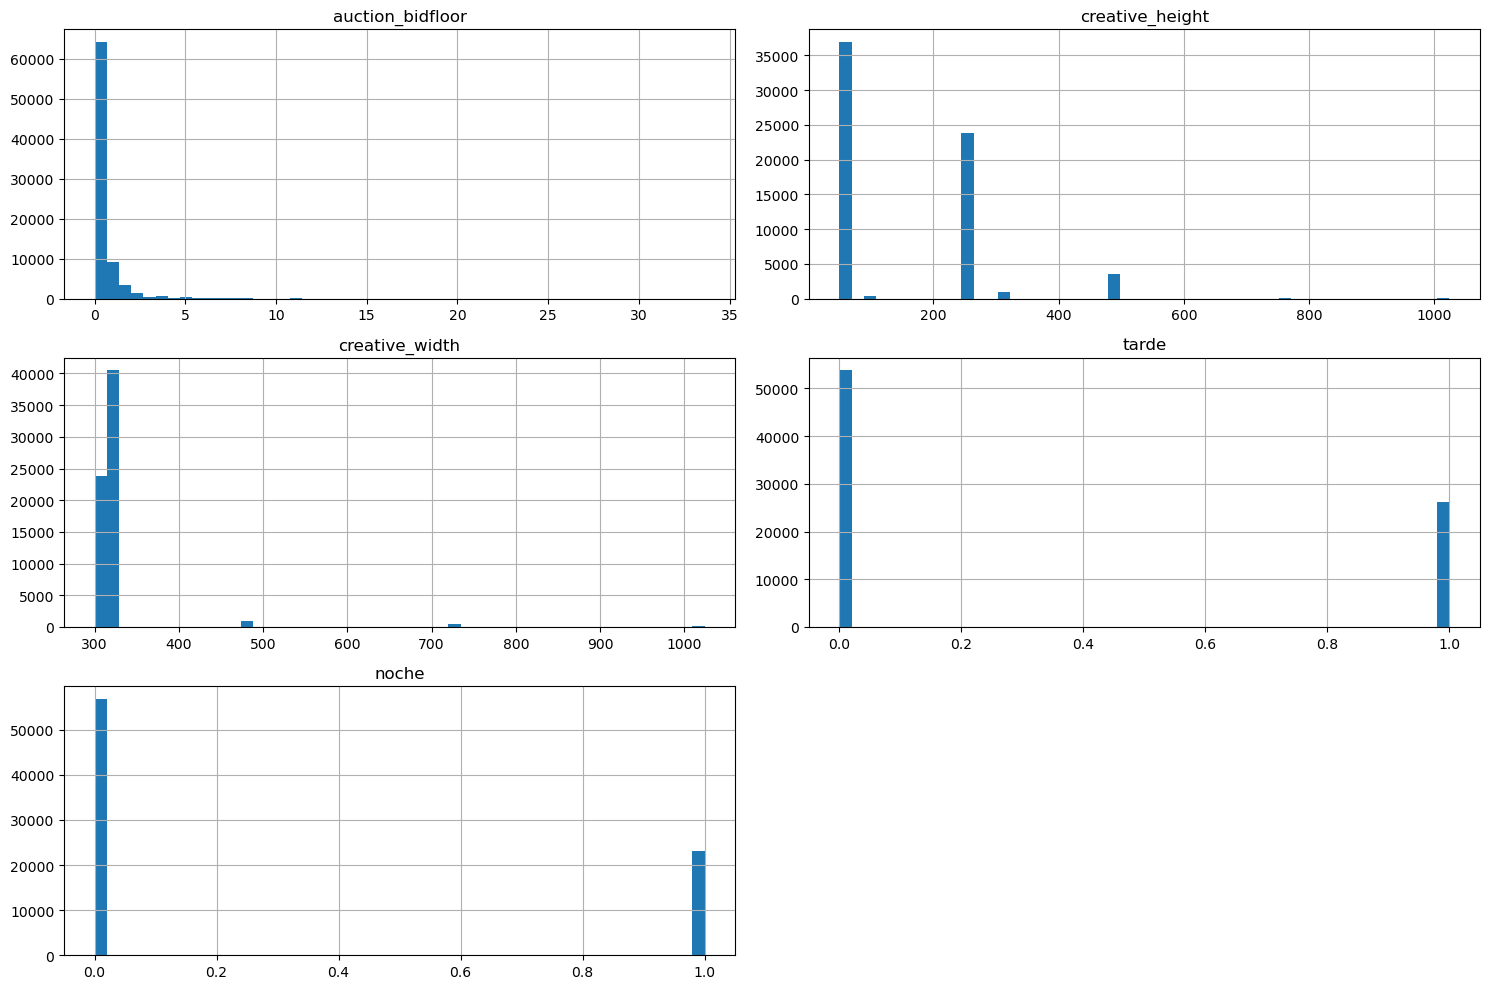

Shape of preprocessed data: (80000, 5209)
Preprocessed data is not in the expected format. Please check the preprocessor output.
Data type: <class 'scipy.sparse._csr.csr_matrix'>
Shape: (80000, 5209)
Sample of data:   (0, 0)	32.0
  (0, 1)	0.02
  (0, 2)	250.0
  (0, 3)	300.0
  (0, 4)	4.0
  (0, 7)	1.0
  (0, 87)	1.0
  (0, 194)	1.0
  (0, 251)	1.0
  (0, 384)	1.0
  (0, 419)	1.0
  (0, 439)	1.0
  (0, 459)	1.0
  (0, 846)	1.0
  (0, 918)	1.0
  (0, 919)	1.0
  (0, 920)	1.0
  (0, 924)	1.0
  (0, 926)	1.0
  (0, 931)	1.0
  (0, 968)	1.0
  (0, 1056)	1.0
  (0, 1116)	1.0
  (0, 2350)	1.0
  (0, 2650)	1.0
  :	:
  (4, 922)	1.0
  (4, 926)	1.0
  (4, 931)	1.0
  (4, 935)	1.0
  (4, 1054)	1.0
  (4, 1056)	1.0
  (4, 1894)	1.0
  (4, 2623)	1.0
  (4, 2650)	1.0
  (4, 2837)	1.0
  (4, 3163)	1.0
  (4, 3333)	1.0
  (4, 4041)	1.0
  (4, 4838)	1.0
  (4, 5120)	1.0
  (4, 5131)	1.0
  (4, 5142)	1.0
  (4, 5152)	1.0
  (4, 5155)	1.0
  (4, 5164)	1.0
  (4, 5183)	1.0
  (4, 5194)	1.0
  (4, 5200)	1.0
  (4, 5202)	1.0
  (4, 5204)	1.0


In [18]:
# Distribution of top features
top_features = feature_importances_df['Feature'].head(10).tolist()
available_features = [f for f in top_features if f in X_train.columns]
X_train[available_features].hist(figsize=(15, 10), bins=50)
plt.tight_layout()
plt.show()

# Prepare data for RFECV
X_train_preprocessed = pipeline_rf.named_steps['preprocessor'].transform(X_train)

# Check the shape of the preprocessed data
print(f"Shape of preprocessed data: {X_train_preprocessed.shape}")

# If X_train_preprocessed is a 2D array with only one column, we need to reshape it
if X_train_preprocessed.ndim == 2 and X_train_preprocessed.shape[1] == 1:
    X_train_preprocessed = X_train_preprocessed.reshape(-1)

# Now check if it's a 1D array
if X_train_preprocessed.ndim == 1:
    X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=['preprocessed_feature'])
    
    # Recursive Feature Elimination with Random Forest
    rfe_selector_rf = RFECV(estimator=RandomForestClassifier(random_state=random_state), step=1, cv=5, scoring='roc_auc')
    rfe_selector_rf = rfe_selector_rf.fit(X_train_preprocessed, y_train)

    # Recursive Feature Elimination with XGBoost
    rfe_selector_xgb = RFECV(estimator=XGBClassifier(random_state=random_state), step=1, cv=5, scoring='roc_auc')
    rfe_selector_xgb = rfe_selector_xgb.fit(X_train_preprocessed, y_train)

    print('Optimal number of features (Random Forest model): {}'.format(rfe_selector_rf.n_features_))
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(rfe_selector_rf.grid_scores_) + 1), rfe_selector_rf.grid_scores_)
    plt.title('Feature Number Selection (Random Forest)')
    plt.xlabel("Number of Features Selected")
    plt.ylabel("CV Score (ROC AUC)")
    plt.show()

    print('Optimal number of features (XGBoost model): {}'.format(rfe_selector_xgb.n_features_))
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(rfe_selector_xgb.grid_scores_) + 1), rfe_selector_xgb.grid_scores_)
    plt.title('Feature Number Selection (XGBoost)')
    plt.xlabel("Number of Features Selected")
    plt.ylabel("CV Score (ROC AUC)")
    plt.show()
else:
    print("Preprocessed data is not in the expected format. Please check the preprocessor output.")
    print(f"Data type: {type(X_train_preprocessed)}")
    print(f"Shape: {X_train_preprocessed.shape}")
    print(f"Sample of data: {X_train_preprocessed[:5]}")